In [1]:
import numpy as np
import gpflow as gp
import tensorflow as tf
import tensorflow_probability as tfp
import pylab as plt
import os
from timeit import default_timer


In [17]:
data_dir = '/home/albert/Dropbox/selective_sync/Fluxus_Glacialis/data/set8/'


#Na, Nd, Nt
dtecs = np.load(os.path.join(data_dir,'simDTECs.npy'))
Na, Nd, Nt = dtecs.shape
#Nt, Nd, Na
dtecs = dtecs.transpose((2,1,0))

dtecs /= np.std(dtecs)

dtec_sigma = 0.5
dtecs += dtec_sigma*np.random.normal(size=dtecs.shape)

#Na, 3
antennas = np.stack([np.load(os.path.join(data_dir,'simAntennaXs.npy')),
                     np.load(os.path.join(data_dir,'simAntennaYs.npy')),
                     np.load(os.path.join(data_dir,'simAntennaZs.npy'))],axis=1)

#Nd, 2
directions = np.stack([np.load(os.path.join(data_dir,'simAnglesX.npy')),
                     np.load(os.path.join(data_dir,'simAnglesZ.npy'))],axis=1)
directions *= np.pi/180.
directions = np.angle(np.exp(1j*directions))
alpha = np.cos(directions[:,0])*np.sin(directions[:,1])
beta = np.sin(directions[:,0])*np.sin(directions[:,1])
directions = np.stack([alpha,beta],axis=1)

#Nt, 1
times = np.load(os.path.join(data_dir,'simTimes.npy'))[:,None]

def make_coord_array(*X,flat=True):
    """
    Return the design matrix from coordinates.
    """
    def add_dims(x,where,sizes):
        shape = []
        tiles = []
        for i in range(len(sizes)):
            if i not in where:
                shape.append(1)
                tiles.append(sizes[i])
            else:
                shape.append(-1)
                tiles.append(1)
        return np.tile(np.reshape(x,shape),tiles)
    N = [x.shape[0] for x in X]
    X_ = []

    for i,x in enumerate(X):
        for dim in range(x.shape[1]):
            X_.append(add_dims(x[:,dim],[i], N))
    X = np.stack(X_,axis=-1)
    if not flat:
        return X 
    return np.reshape(X,(-1,X.shape[-1]))

X = make_coord_array(times, directions, antennas)
Y = dtecs.reshape((-1,1))


In [41]:
with tf.Session(graph=tf.Graph()) as sess:
#     kern = gp.kernels.RBF(6,ARD=True,
#                           lengthscales=[1., np.std(directions), np.std(directions),10.,10.,10.],variance = np.var(dtecs))
    kern_time = gp.kernels.RBF(1,active_dims=slice(0,1,1),lengthscales=10.,variance = np.var(dtecs))
    kern_dir = gp.kernels.RBF(2,active_dims=slice(1,3,1),lengthscales=np.std(directions),variance = 1.)
    kern_dir.variance.trainable = False
    kern_ant = gp.kernels.RBF(3,active_dims=slice(3,6,1),lengthscales=10.,variance = 1.)
    kern_ant.variance.trainable = False
    kern = kern_time*kern_dir*kern_ant
    m = gp.models.GPR(X,Y,kern)
    m.likelihood.variance = dtec_sigma**2
    m.likelihood.trainable = False
    print(m.compute_log_likelihood())
    
    gp.train.ScipyOptimizer().minimize(m,maxiter=1000)
    print(m.compute_log_likelihood())
    
    print(m.predict_density(X,Y).sum())
    

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:61: DeprecationWarning: tf_float is deprecated and will be removed at GPflow version 1.2.0. Use float_

-1035.4126660147076
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 940.382778
  Number of iterations: 20
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 940.382778
  Number of iterations: 20
  Number of functions evaluations: 21


-940.3827776222364


/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:61: DeprecationWarning: tf_float is deprecated and will be removed at GPflow version 1.2.0. Use float_type.
  'version 1.2.0. Use float_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use in

-797.1574224630469


In [19]:
m.as_pandas_table().style

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,10.0
GPR/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,5.484571092596265
GPR/kern/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,0.04124122185393538
GPR/kern/kernels/1/variance,Parameter,None,+ve,False,(),True,1.0
GPR/kern/kernels/2/lengthscales,Parameter,None,+ve,True,(),True,17.853175034249197
GPR/kern/kernels/2/variance,Parameter,None,+ve,False,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,False,(),True,0.25


In [35]:
from functools import reduce
import warnings

import tensorflow as tf
import numpy as np

from gpflow import transforms
from gpflow import settings

from gpflow.params import Parameter, Parameterized, ParamList
from gpflow.decors import params_as_tensors, autoflow

float_type = settings.float_type

class TECKernel(gp.kernels.Kernel):
    def __init__(self, input_dim, variance=1.0, lengthscales=10.0,
                 velocity=[0.,0.,0.], a = 250., b = 50., resolution=10,
                 active_dims=None, name=None):
        """
        - input_dim is the dimension of the input to the kernel
        - variance is the (initial) value for the variance parameter
        - lengthscales is the initial value for the lengthscales parameter
          defaults to 1.0 (ARD=False) or np.ones(input_dim) (ARD=True).
        - active_dims is a list of length input_dim which controls which
          columns of X are used.
        """
        super().__init__(input_dim, active_dims, name=name)
        self.variance = Parameter(variance, transform=transforms.positive,
                                  dtype=settings.float_type)
        # (3,)
        self.lengthscales = Parameter(lengthscales, transform=transforms.positive,
                                      dtype=settings.float_type)
        # (3,)
        self.velocity = Parameter(velocity, transform=transforms.positive,
                                      dtype=settings.float_type)
        self.a = Parameter(a, transform=transforms.positive,
                                      dtype=settings.float_type)
        self.b = Parameter(b, transform=transforms.positive,
                                      dtype=settings.float_type)
        self.resolution = resolution

    @params_as_tensors
    def Kdiag(self, X, presliced=False):
        if not presliced:
            X, _ = self._slice(X, None)
        return tf.diag_part(self.K(X,None))

    @params_as_tensors
    def K(self, X, X2=None, presliced=False):
        
        if not presliced:
            X, X2 = self._slice(X, X2)
        
        if X2 is None:
            X2 = X
            
        
        #N
        times = X[:,0]
        #N,3
        directions = tf.concat([X[:,slice(1,3,1)], tf.sqrt(1. - tf.reduce_sum(tf.square(X[:,slice(1,3,1)]),axis=1,keepdims=True))], axis=1)
        
        #N,3
        antennas = X[:,slice(3,6,1)]
        
        #Np
        times2 = X2[:,0]
        #Np,2
        directions2 = X2[:,slice(1,3,1)]
        #Np,3
        directions2 = tf.concat([X2[:,slice(1,3,1)], tf.sqrt(1. - tf.reduce_sum(tf.square(X2[:,slice(1,3,1)]),axis=1,keepdims=True))], axis=1)
        #Np,3
        antennas2 = X2[:,slice(3,6,1)]
        
        # l1 = 1, l2 = 1
        # assume x0 = 0,0,0
        
        #N
        sec1 = tf.reciprocal(directions[:,2],name='sec1')
        #N
        s1m = sec1*(self.a  - (antennas - self.velocity[None,:]*times[:,None])[:,2]) - 0.5*sec1*self.b
        #N
        s1p = sec1*(self.a  - (antennas - self.velocity[None,:]*times[:,None])[:,2]) + 0.5*sec1*self.b
        
        #Np
        sec2 = tf.reciprocal(directions2[:,2],name='sec2')
        #Np
        s2m = sec2*(self.a  - (antennas2 - self.velocity[None,:]*times2[:,None])[:,2]) - 0.5*sec2*self.b
        #Np
        s2p = sec2*(self.a  - (antennas2 - self.velocity[None,:]*times2[:,None])[:,2]) + 0.5*sec2*self.b
        
        #res, N
        s1 = s1m[None,:] + ((s1p - s1m)[None,:])*tf.cast(tf.linspace(0.,1.,self.resolution)[:,None],float_type)
#         #res, N, Np
#         s1 = tf.tile(s1[:,:,None],tf.concat([[1],[1], tf.shape(X2)[0:1]],axis=0))
        #res, Np
        s2 = s2m[None,:] + ((s2p - s2m)[None,:])*tf.cast(tf.linspace(0.,1.,self.resolution)[:,None],float_type)
#         #res, N, Np
#         s1 = tf.tile(s1[:,None,:],tf.concat([[1], tf.shape(X)[0:1],[1]],axis=0))
        #N
        ds1 = s1[1,:] - s1[0,:]
        #Np
        ds2 = s2[1,:] - s2[0,:]
        #N,Np
        ds1ds2 = ds1[:,None]*ds2[None,:]
        
        #res, N, 3
        y1 = antennas[None,:,:] - self.velocity[None,None, :]*times[None, :, None] + directions[None, :, :]*s1[:,:,None]
        shape1 = tf.shape(y1)
        # res1 N, 3
        y1 = tf.reshape(y1,(-1, 3))
        
        #res, Np, 3
        y2 = antennas2[None,:,:] - self.velocity[None,None, :]*times2[None, :, None] + directions2[None, :, :]*s2[:,:,None]  
        shape2 = tf.shape(y2)
        # res2 Np, 3
        y2 = tf.reshape(y2,(-1, 3))
#         #res1, res2, N, Np, 3
#         y1 = tf.tile(y1[:,None, :, None, :],tf.concat([[1],[self.resolution], [1], tf.shape(X2)[0:1], [1]],axis=0))
#         shape1 = tf.shape(y1)
#         # res1 res2 N Np, 3
#         y1 = tf.reshape(y1,(-1, 3))
#         #res1, res2, N, Np, 3
#         y2 = tf.tile(y2[None, :, None, :, :],tf.concat([[self.resolution], [1], tf.shape(X)[0:1], [1], [1]],axis=0))
#         shape2 = tf.shape(y2)
#         # res1 res2 N Np, 3
#         y2 = tf.reshape(y2,(-1, 3))
        
        
        iono_kern = tfp.positive_semidefinite_kernels.ExponentiatedQuadratic(amplitude=self.variance,
                                                                        length_scale=self.lengthscales,
                                                                        feature_ndims=1)
        #res1 N, res2 Np
        K = iono_kern.matrix(y1,y2)
        shape = tf.concat([shape1[:2],shape2[:2]],axis=0)
        #res1, N, res2, Np
        K = tf.reshape(K,shape)
        #N,Np
        I = tf.reduce_sum(K,axis=[0,2])*ds1ds2
        return I
    
class DTECKernel(gp.kernels.Kernel):
    def __init__(self, input_dim, variance=1.0, lengthscales=10.0,
                 velocity=[0.,0.,0.], a = 250., b = 50., resolution=10,
                 active_dims=None, name=None):
        """
        - input_dim is the dimension of the input to the kernel
        - variance is the (initial) value for the variance parameter
        - lengthscales is the initial value for the lengthscales parameter
          defaults to 1.0 (ARD=False) or np.ones(input_dim) (ARD=True).
        - active_dims is a list of length input_dim which controls which
          columns of X are used.
        """
        super().__init__(input_dim, active_dims, name=name)
        self.variance = Parameter(variance, transform=transforms.positive,
                                  dtype=settings.float_type)
        # (3,)
        self.lengthscales = Parameter(lengthscales, transform=transforms.positive,
                                      dtype=settings.float_type)
        # (3,)
        self.velocity = Parameter(velocity, transform=transforms.positive,
                                      dtype=settings.float_type)
        self.a = Parameter(a, transform=transforms.positive,
                                      dtype=settings.float_type)
        self.b = Parameter(b, transform=transforms.positive,
                                      dtype=settings.float_type)
        self.resolution = resolution

    @params_as_tensors
    def Kdiag(self, X, presliced=False):
        if not presliced:
            X, _ = self._slice(X, None)
        return tf.diag_part(self.K(X,None))

    @params_as_tensors
    def K(self, X, X2=None, presliced=False):
        
        if not presliced:
            X, X2 = self._slice(X, X2)
        
        if X2 is None:
            X2 = X
            
        iono_kern = tfp.positive_semidefinite_kernels.ExponentiatedQuadratic(amplitude=self.variance,
                                                                             length_scale=self.lengthscales,
                                                                            feature_ndims=1)

        
        #N
        times = X[:,0]
        #N,3
        directions = tf.concat([X[:,slice(1,3,1)], tf.sqrt(1. - tf.reduce_sum(tf.square(X[:,slice(1,3,1)]),axis=1,keepdims=True))], axis=1)
        
        #N,3
        antennas = X[:,slice(3,6,1)]
        
        #Np
        times2 = X2[:,0]
        #Np,2
        directions2 = X2[:,slice(1,3,1)]
        #Np,3
        directions2 = tf.concat([X2[:,slice(1,3,1)], tf.sqrt(1. - tf.reduce_sum(tf.square(X2[:,slice(1,3,1)]),axis=1,keepdims=True))], axis=1)
        #Np,3
        antennas2 = X2[:,slice(3,6,1)]
        
        # l1 = 0, l2 = 0
        # assume x0 = 0,0,0
        
        #N
        sec1 = tf.reciprocal(directions[:,2],name='sec1')
        #Np
        sec2 = tf.reciprocal(directions2[:,2],name='sec2')
        
        #N
        ds1 = sec1*self.b/tf.cast(self.resolution - 1,float_type)
        #Np
        ds2 = sec1*self.b/tf.cast(self.resolution - 1,float_type)
        #N,Np
        ds1ds2 = ds1[:,None]*ds2[None,:]
        
        ###
        # 1 1 terms
        #N
        s1m = sec1*(self.a  - (antennas[:,2] - self.velocity[2]*times)) - 0.5*sec1*self.b
        #N
        s1p = sec1*(self.a  - (antennas[:,2] - self.velocity[2]*times)) + 0.5*sec1*self.b
        
        
        #Np
        s2m = sec2*(self.a  - (antennas2[:,2] - self.velocity[2]*times2)) - 0.5*sec2*self.b
        #Np
        s2p = sec2*(self.a  - (antennas2[:,2] - self.velocity[2]*times2)) + 0.5*sec2*self.b
        
        #res, N
        s1 = s1m[None,:] + ((s1p - s1m)[None,:])*tf.cast(tf.linspace(0.,1.,self.resolution)[:,None],float_type)
#         #res, N, Np
#         s1 = tf.tile(s1[:,:,None],tf.concat([[1],[1], tf.shape(X2)[0:1]],axis=0))
        #res, Np
        s2 = s2m[None,:] + ((s2p - s2m)[None,:])*tf.cast(tf.linspace(0.,1.,self.resolution)[:,None],float_type)
#         #res, N, Np
#         s1 = tf.tile(s1[:,None,:],tf.concat([[1], tf.shape(X)[0:1],[1]],axis=0))
        
        ###
        # 0 0 terms
        #N
        s1m_ = sec1*(self.a + self.velocity[2]*times) - 0.5*sec1*self.b
        #N
        s1p_ = sec1*(self.a + self.velocity[2]*times) + 0.5*sec1*self.b
        
        #Np
        s2m_ = sec2*(self.a  + self.velocity[2]*times2) - 0.5*sec2*self.b
        #Np
        s2p_ = sec2*(self.a  + self.velocity[2]*times2) + 0.5*sec2*self.b
        
        #res, N
        s1_ = s1m_[None,:] + ((s1p_ - s1m_)[None,:])*tf.cast(tf.linspace(0.,1.,self.resolution)[:,None],float_type)
#         #res, N, Np
#         s1 = tf.tile(s1[:,:,None],tf.concat([[1],[1], tf.shape(X2)[0:1]],axis=0))
        #res, Np
        s2_ = s2m_[None,:] + ((s2p_ - s2m_)[None,:])*tf.cast(tf.linspace(0.,1.,self.resolution)[:,None],float_type)
#         #res, N, Np
#         s1 = tf.tile(s1[:,None,:],tf.concat([[1], tf.shape(X)[0:1],[1]],axis=0))
        
                       
        # I00
        
        #res, N, 3
        y1 = antennas[None,:,:] - self.velocity[None,None, :]*times[None, :, None] + directions[None, :, :]*s1[:,:,None]
        shape1 = tf.shape(y1)
        # res1 N, 3
        y1 = tf.reshape(y1,(-1, 3))
        
        #res, Np, 3
        y2 = antennas2[None,:,:] - self.velocity[None,None, :]*times2[None, :, None] + directions2[None, :, :]*s2[:,:,None]  
        shape2 = tf.shape(y2)
        # res2 Np, 3
        y2 = tf.reshape(y2,(-1, 3))        
        
                                                                        
        #res1 N, res2 Np
        K = iono_kern.matrix(y1,y2)
        shape = tf.concat([shape1[:2],shape2[:2]],axis=0)
        #res1, N, res2, Np
        K = tf.reshape(K,shape)
        
        #N,Np
        I00 = 0.25*ds1ds2 * tf.add_n([K[0,:,0,:], 
                               K[1,:,0,:], 
                               K[0,:,1,:], 
                               K[1,:,1,:],
                               2*tf.reduce_sum(K[1,:,:,:],axis=[1]),
                               2*tf.reduce_sum(K[0,:,:,:],axis=[1]),
                               2*tf.reduce_sum(K[:,:,1,:],axis=[0]),
                               2*tf.reduce_sum(K[:,:,0,:],axis=[0]),
                               4*tf.reduce_sum(K[1:-1,:,1:-1,:],axis=[0,2])])
        # I10
        
        #res, N, 3
        y1 = - self.velocity[None,None, :]*times[None, :, None] + directions[None, :, :]*s1_[:,:,None]
        shape1 = tf.shape(y1)
        # res1 N, 3
        y1 = tf.reshape(y1,(-1, 3))
        
        #res, Np, 3
        y2 = antennas2[None,:,:] - self.velocity[None,None, :]*times2[None, :, None] + directions2[None, :, :]*s2[:,:,None]  
        shape2 = tf.shape(y2)
        # res2 Np, 3
        y2 = tf.reshape(y2,(-1, 3))        
        
                                                                        
        #res1 N, res2 Np
        K = iono_kern.matrix(y1,y2)
        shape = tf.concat([shape1[:2],shape2[:2]],axis=0)
        #res1, N, res2, Np
        K = tf.reshape(K,shape)
        #N,Np
        I10 = 0.25*ds1ds2 * tf.add_n([K[0,:,0,:], 
                               K[1,:,0,:], 
                               K[0,:,1,:], 
                               K[1,:,1,:],
                               2*tf.reduce_sum(K[1,:,:,:],axis=[1]),
                               2*tf.reduce_sum(K[0,:,:,:],axis=[1]),
                               2*tf.reduce_sum(K[:,:,1,:],axis=[0]),
                               2*tf.reduce_sum(K[:,:,0,:],axis=[0]),
                               4*tf.reduce_sum(K[1:-1,:,1:-1,:],axis=[0,2])])
        # I01
        
        #res, N, 3
        y1 = antennas[None,:,:] - self.velocity[None,None, :]*times[None, :, None] + directions[None, :, :]*s1[:,:,None]
        shape1 = tf.shape(y1)
        # res1 N, 3
        y1 = tf.reshape(y1,(-1, 3))
        
        #res, Np, 3
        y2 =  - self.velocity[None,None, :]*times2[None, :, None] + directions2[None, :, :]*s2_[:,:,None]  
        shape2 = tf.shape(y2)
        # res2 Np, 3
        y2 = tf.reshape(y2,(-1, 3))        
        
                                                                        
        #res1 N, res2 Np
        K = iono_kern.matrix(y1,y2)
        shape = tf.concat([shape1[:2],shape2[:2]],axis=0)
        #res1, N, res2, Np
        K = tf.reshape(K,shape)
        #N,Np
        I01 = 0.25*ds1ds2 * tf.add_n([K[0,:,0,:], 
                               K[1,:,0,:], 
                               K[0,:,1,:], 
                               K[1,:,1,:],
                               2*tf.reduce_sum(K[1,:,:,:],axis=[1]),
                               2*tf.reduce_sum(K[0,:,:,:],axis=[1]),
                               2*tf.reduce_sum(K[:,:,1,:],axis=[0]),
                               2*tf.reduce_sum(K[:,:,0,:],axis=[0]),
                               4*tf.reduce_sum(K[1:-1,:,1:-1,:],axis=[0,2])])
        
        # I11
        
        #res, N, 3
        y1 = - self.velocity[None,None, :]*times[None, :, None] + directions[None, :, :]*s1_[:,:,None]
        shape1 = tf.shape(y1)
        # res1 N, 3
        y1 = tf.reshape(y1,(-1, 3))
        
        #res, Np, 3
        y2 =  - self.velocity[None,None, :]*times2[None, :, None] + directions2[None, :, :]*s2_[:,:,None]  
        shape2 = tf.shape(y2)
        # res2 Np, 3
        y2 = tf.reshape(y2,(-1, 3))        
        
                                                                        
        #res1 N, res2 Np
        K = iono_kern.matrix(y1,y2)
        shape = tf.concat([shape1[:2],shape2[:2]],axis=0)
        #res1, N, res2, Np
        K = tf.reshape(K,shape)
        #N,Np
        I11 = 0.25*ds1ds2 * tf.add_n([K[0,:,0,:], 
                               K[1,:,0,:], 
                               K[0,:,1,:], 
                               K[1,:,1,:],
                               2*tf.reduce_sum(K[1,:,:,:],axis=[1]),
                               2*tf.reduce_sum(K[0,:,:,:],axis=[1]),
                               2*tf.reduce_sum(K[:,:,1,:],axis=[0]),
                               2*tf.reduce_sum(K[:,:,0,:],axis=[0]),
                               4*tf.reduce_sum(K[1:-1,:,1:-1,:],axis=[0,2])])
        
        
        return I00 + I11 - I01 - I10
        

    

In [8]:
kern = TECKernel(6,
                variance=1e-3, lengthscales=10.0,
                velocity=[0.,0.,0.], a = 250., b = 100., resolution=10)
K20 = kern.compute_K_symm(X)

kern = DTECKernel(6,
                variance=1e-3, lengthscales=10.0,
                velocity=[0.,0.,0.], a = 250., b = 100., resolution=10)
dK20 = kern.compute_K_symm(X)

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)


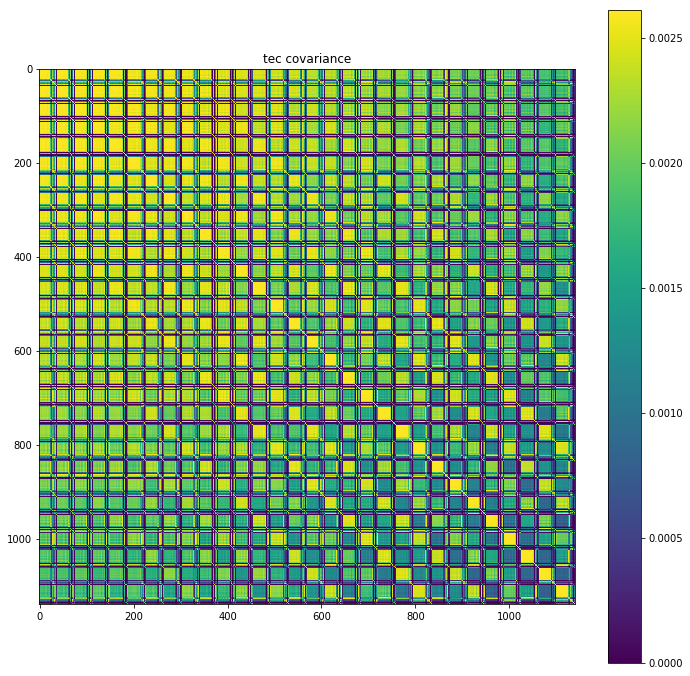

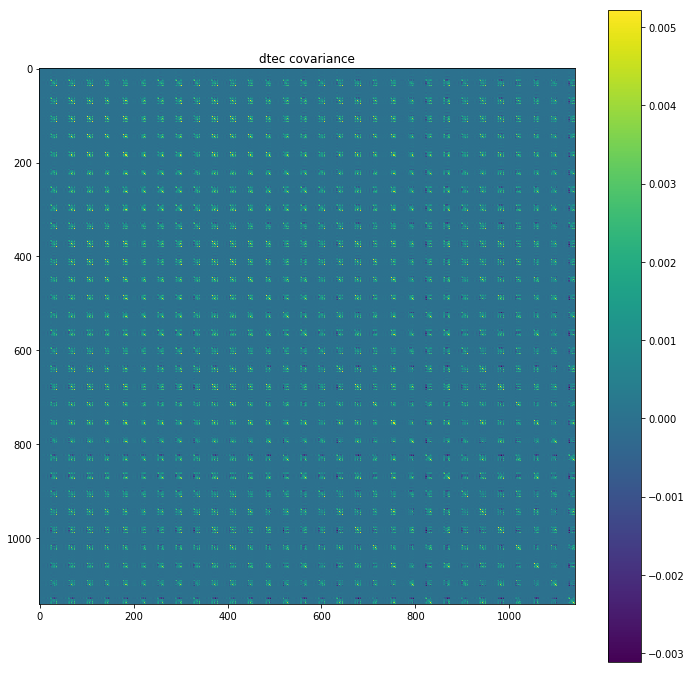

In [9]:
plt.figure(figsize=(12,12))
plt.imshow(K20)
plt.colorbar()
plt.title('tec covariance')
plt.show()

plt.figure(figsize=(12,12))
plt.imshow(dK20)
plt.colorbar()
plt.title('dtec covariance')
plt.show()

In [10]:
L20 = np.linalg.cholesky(K20 + 1e-6*np.eye(K20.shape[0]))
dL20 = np.linalg.cholesky(dK20 + 1e-6*np.eye(dK20.shape[0]))

In [11]:
tec_samples = np.einsum('ab,bc->ac',L20, np.random.normal(size=(L20.shape[0], 100)))
dtec_samples = np.einsum('ab,bc->ac',dL20, np.random.normal(size=(dL20.shape[0], 100)))

In [12]:

tec_samples = tec_samples.reshape((Nt,Nd,Na,100))
tec_samples -= tec_samples[:,:,0:1,:]
dtec_samples = dtec_samples.reshape((Nt,Nd,Na,100))
dist = np.linalg.norm(antennas - antennas[0,:],axis=1)
sort = np.argsort(dist,axis=0)
tec_samples = tec_samples[:,:,sort,:]
dtec_samples = dtec_samples[:,:,sort,:]

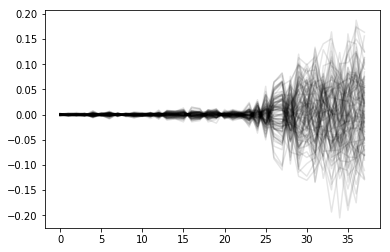

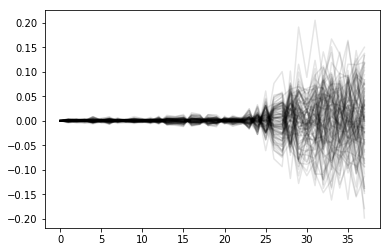

In [13]:

plt.plot(dtec_samples[0,0,:,:],c='black',alpha=0.1)
plt.show()
plt.plot(tec_samples[0,0,:,:],c='black',alpha=0.1)
plt.show()

## Numerical accuracy test

In [ ]:
times = []
abs_error = []
rel_error = []

def piecewise(X,kern):
    N = X.shape[0]>>1
    h = np.concatenate([np.concatenate([kern.compute_K(X[:N,:],X[:N,:]), kern.compute_K(X[:N,:],X[N:,:])],axis=1),
                        np.concatenate([kern.compute_K(X[N:,:],X[:N,:]), kern.compute_K(X[N:,:],X[N:,:])],axis=1)],axis=0)
    return h

kern = TECKernel(6,
                variance=1e-3, lengthscales=10.0,
                velocity=[0.,0.,0.], 
                 a = 250., b = 100., resolution=48)
K_ref = piecewise(X, kern)

kern = DTECKernel(6,
                variance=1e-3, lengthscales=10.0,
                velocity=[0.,0.,0.], 
                 a = 250., b = 100., resolution=48)
dK_ref = piecewise(X, kern)

for n in [2,4,8,16,32,40]:
    t0 = default_timer()
    kern = TECKernel(6,
                    variance=1e-3, lengthscales=10.0,
                    velocity=[0.,0.,0.], 
                     a = 250., b = 100., resolution=n)
    t1 = default_timer() - t0
    K = piecewise(X, kern)

    t0 = default_timer()
    kern = DTECKernel(6,
                    variance=1e-3, lengthscales=10.0,
                    velocity=[0.,0.,0.], 
                     a = 250., b = 100., resolution=n)
    t2 = default_timer() - t0
    dK = piecewise(X, kern)
    
    times.append((t1,t2))
    abs_error.append((np.mean(np.abs(K - K_ref)), np.mean(np.abs(dK - dK_ref))))
    rel_error.append((np.nanmean(np.abs(K - K_ref)/np.abs(K_ref)), np.nanmean(np.abs(dK - dK_ref)/np.abs(dK_ref))))

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)


In [ ]:
N = [2,4,8,16,32,40]
plt.plot(N,times)
plt.title("times (s)")
plt.show()
plt.plot(N,abs_error)
plt.title("abs error")
plt.yscale('log')
plt.grid()
plt.show()
plt.plot(N,rel_error)
plt.title('rel error')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()

In [36]:
with tf.Session(graph=tf.Graph()) as sess:
    kern = DTECKernel(6,
                    variance=np.var(dtecs), lengthscales=12.0*0.84,
                    velocity=[0.,0.,0.], 
                     a = 250., b = 70., resolution=4)
#     kern.b.trainable = False
#     gp.kernels.RBF(6,ARD=True,
#                           lengthscales=[1., np.std(directions), np.std(directions),10.,10.,10.],variance = np.var(dtecs))
    m = gp.models.GPR(X,Y,kern)
    m.likelihood.variance = dtec_sigma**2
    m.likelihood.variance.trainable = False
    print(m.compute_log_likelihood())
    
    gp.train.ScipyOptimizer().minimize(m,maxiter=1000)
    print(m.compute_log_likelihood())

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:61: DeprecationWarning: tf_float is deprecated and will be removed at GPflow version 1.2.0. Use float_type.
  'version 1.2.0. Use float_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/logdensities.py:91: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('Shape of x must be 2D at computation.')


-1068.242120187992
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 871.051852
  Number of iterations: 39
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 871.051852
  Number of iterations: 39
  Number of functions evaluations: 45


-871.051851891978


In [39]:
m.predict_density(X,Y)

GPflowError: Tensor "GPR" uses different graph.

In [38]:
kern.lengthscales.value / 0.84

14.869369148003013

In [ ]:
m.c